# Achievement 6.6: Sourcing & Analyzing Time Series Data

### Objective: To use existing Project time-series data, or, to import data using QuandL and to wrangle / analyze the data before decomposing the data and conducting stationarity tests and transformations (log / differencing).

#### Our data set already has transactional data, of which there are two options:
- 'Calendar' > The information available in this file only spans one year (as it is an indication of availability & pricing for the up coming season. Because the date range is only 1 year, I don't think it'll provide much additional insight on our prior questions (e.g what months are the most expensive to visit > If we only have one years data we can't assess whether there is trends / seasonality because we don't have the opportunity to review multiple annual cycles).
- 'Review_details' > This file contains review data and has a date for the time the review was posted. It's a fairly large assumption, but we can surmize that a customer would leave a review within a few days (perhaps at most a week or 2) after having completed a stay so the idea here would perhaps be to review 'count of reviews' against time (months) to assess both the tragectory of booking quantities over the years and the popularity of the service for the Amsterdam Region (using some listing_id related data such as property type / group size etc.)

#### Sections:

- Library & data importing
- Data consistency checks, wrangling & cleaning
- Time-series component analysis using decomposition
- Testing for Stationarity
- Stationarizing the data (if  req.)
- Concluding comments

### 1. Importing your libraries and data

In [1]:
#As we are currently using existing data for we won't install QuandL. We may proceed to generating a new script IF these results don't yield any insights

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
from datetime import datetime

plt.style.use('fivethirtyeight')

path = r'C:\Users\mojos\Documents\Career Foundry Course\Data Immersion\Section 6\AirBnB Amsterdam Project\AirBnB Data'

review = pd.read_csv(os.path.join(path,'Raw','reviews_details.csv'))

### 2. Reviewing the available time-series data and performing wrangling / cleaning / merges

In [2]:
# Removing unncessary columns & correcting dtypes
review_2 = review.drop(columns = ['id','reviewer_id','reviewer_name','comments'])
review_2['listing_id'] = review_2['listing_id'].astype('str')
review_2['date_converted'] = pd.to_datetime(review_2['date'])
review_2['month_year'] = review_2['date_converted'].dt.strftime('%Y-%m-01')
review_3 = review_2.drop(columns = ['date','date_converted'])
monthly_count = review_3.groupby('month_year').agg({'listing_id':'count'}).reset_index()
monthly_count = monthly_count.rename(columns = {'listing_id' : 'listing_count'})
monthly_count = monthly_count.set_index('month_year')

In [3]:
monthly_count.to_csv(os.path.join(path,'Monthly_Growth.csv'))

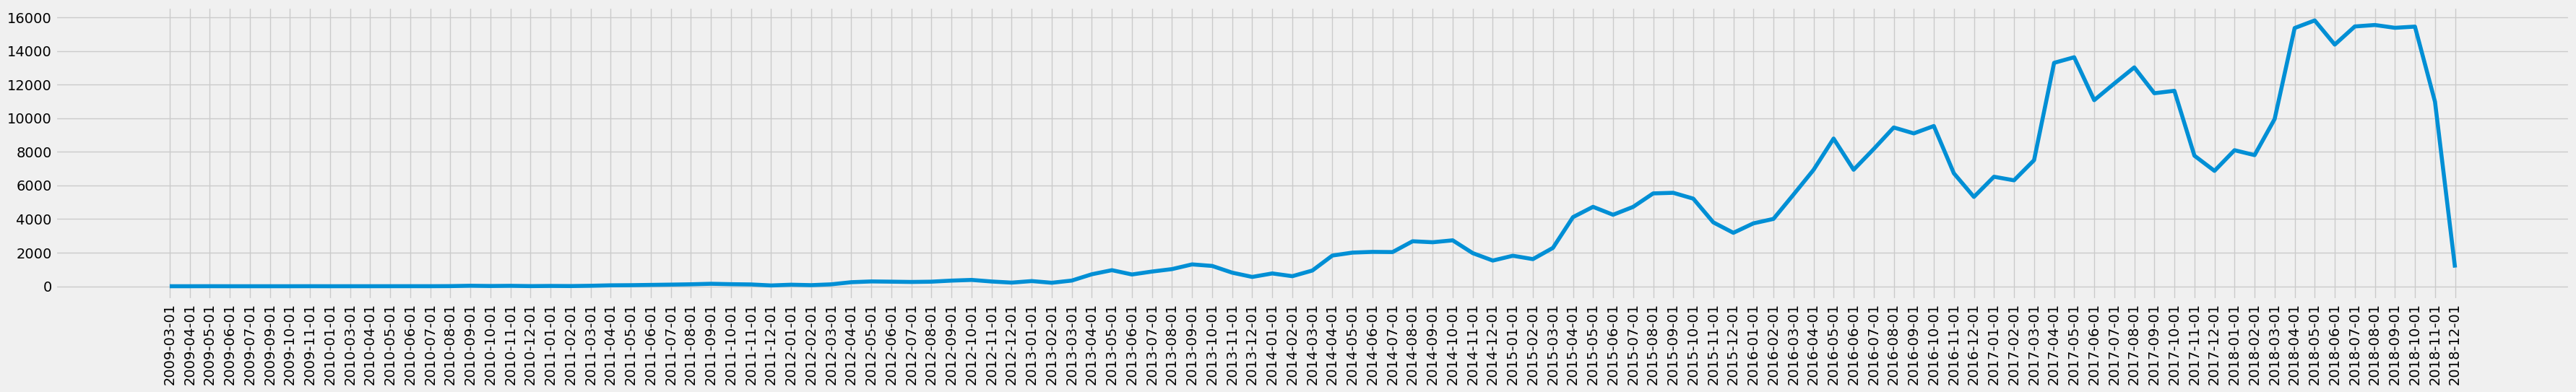

In [4]:
plt.figure(figsize=(40,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!
plt.xticks(rotation=90)
plt.plot(monthly_count)
plt.savefig('prelim_timeseries.png', bbox_inches='tight', dpi=100)

In [5]:
# Create a subset based on values after a certain date range
start_date = '2013-12-01'
end_date = '2018-11-01'
correct_range = monthly_count[monthly_count.index > start_date]
correct_range = correct_range[correct_range.index <= end_date]
correct_range.shape

(59, 1)

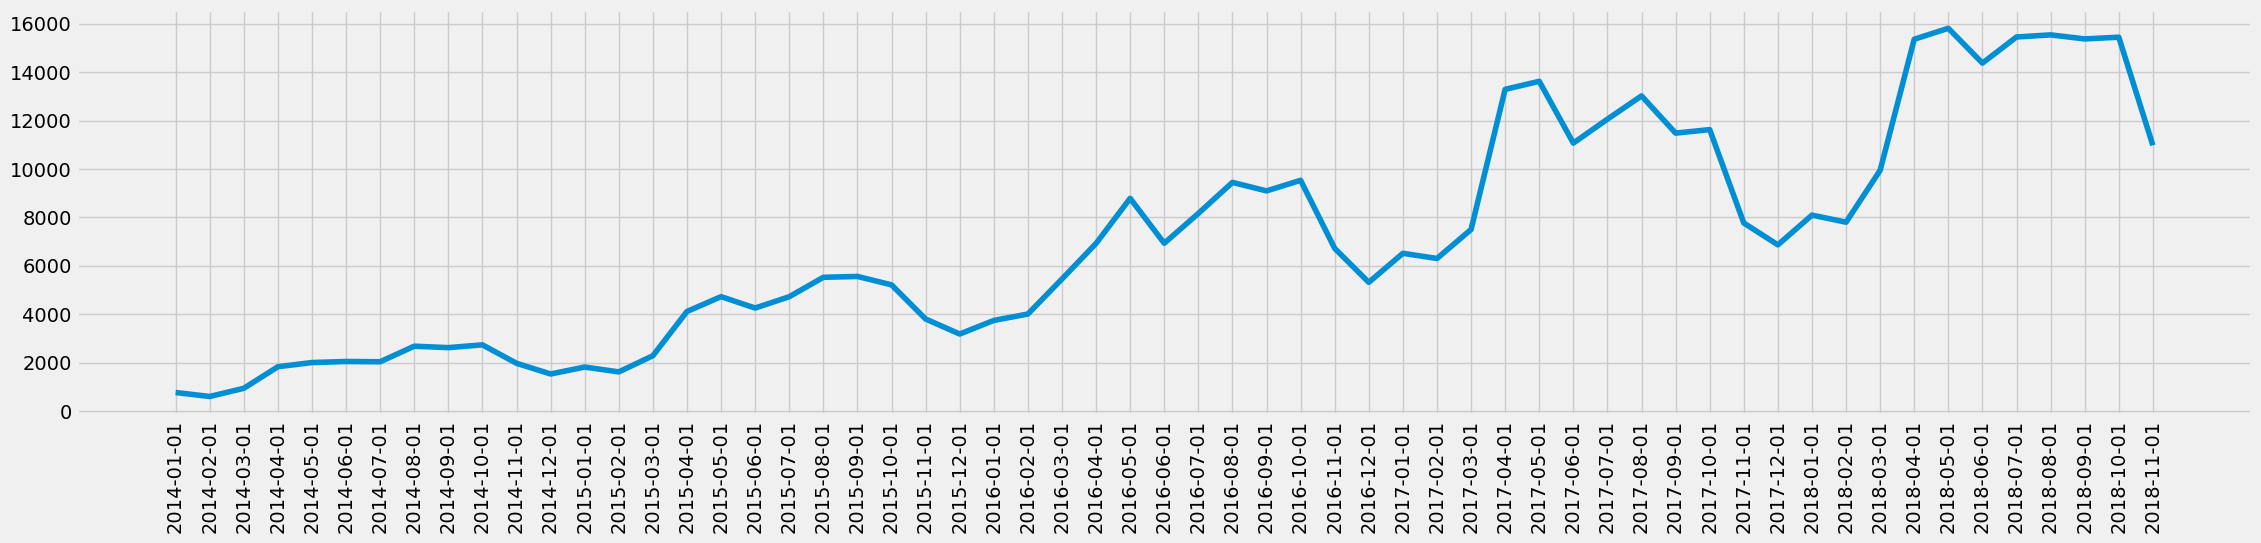

In [6]:
plt.figure(figsize=(25,5), dpi=100)
plt.xticks(rotation=90)
plt.plot(correct_range)
plt.savefig('updated_range_timeseries.png', bbox_inches='tight', dpi=100)

In [7]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

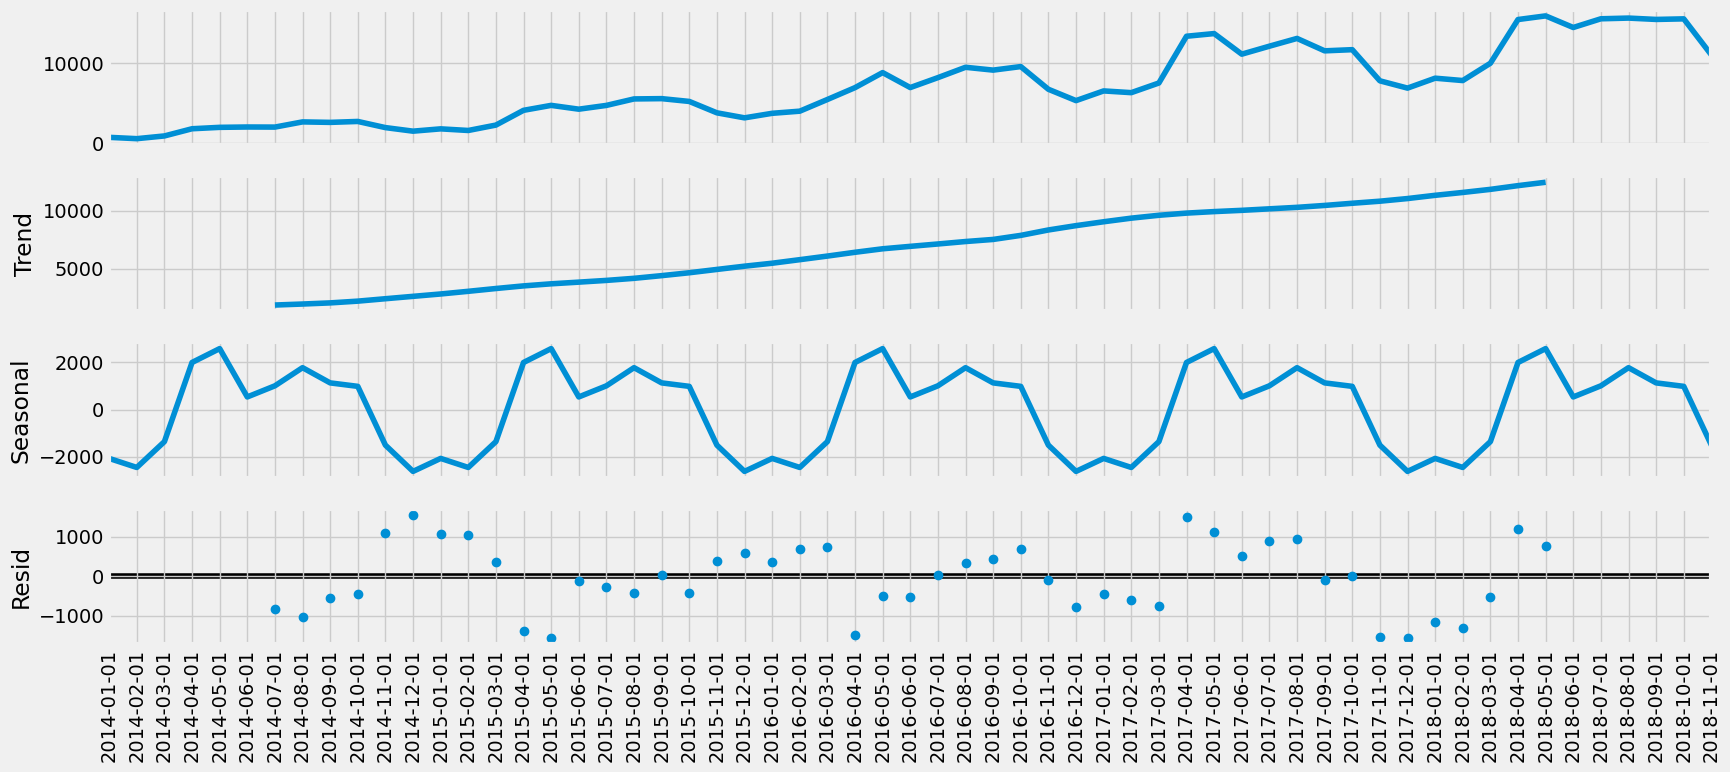

In [8]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(correct_range, model='additive',period = 12)
# Plot the separate components
decomposition.plot()
plt.xticks(rotation=90)
plt.savefig('decomposition_charts', bbox_inches='tight', dpi=100)
plt.show()

#### The LEVEL (first chart) looks as expected, it follows the line of the main data plot. This means that it has an upwards trend with some smaller first quarter dips each year.
#### The Trend also matches our expectation. There is visible smoothening compared to the level with most of the noise associated to those aformention first quarter decreases having been removed. There is a dominant trend.
#### Evidently there is a lot of seasonality in this time series. There are consistent peaks and valleys with a strong variation between the highs/lows respectively.
#### Finally, there is a lot of unexplained noise in the data represented by the 'residual' chart, showing high variability thoughout the years, particularly during the outlined 'seasons' that we anticipated we'd see.

### Section 4: Testing for Stationarity (v1.)

In [9]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(correct_range['listing_count'])

Dickey-Fuller Stationarity test:
Test Statistic                  0.784628
p-value                         0.991384
Number of Lags Used            11.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


#### Since the test statistic value is higher than the Critical Value results, we cannot at this moment disprove the precense of a unit root. This means that our data is, for the time-being, non-stationary.

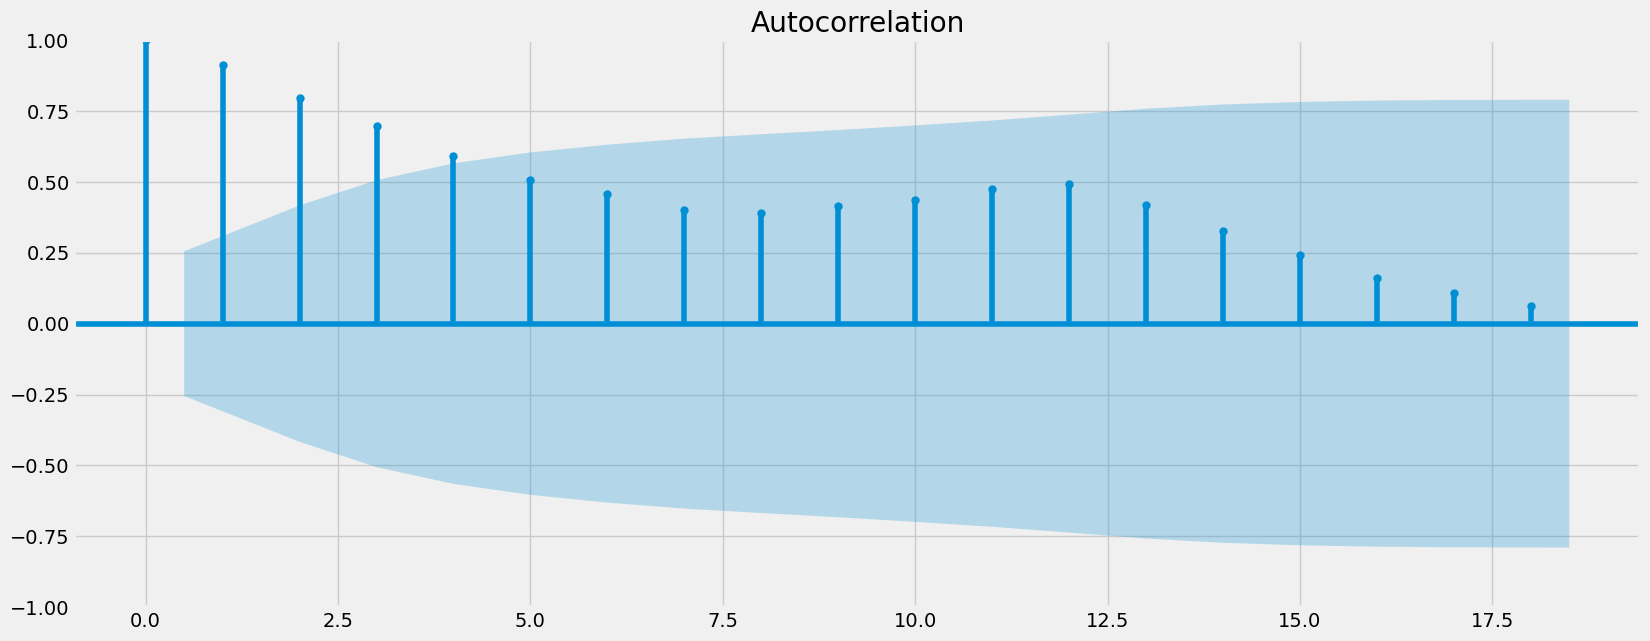

In [10]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(correct_range)
plt.savefig('Auto_correlation_charts', bbox_inches='tight', dpi=100)
plt.show()

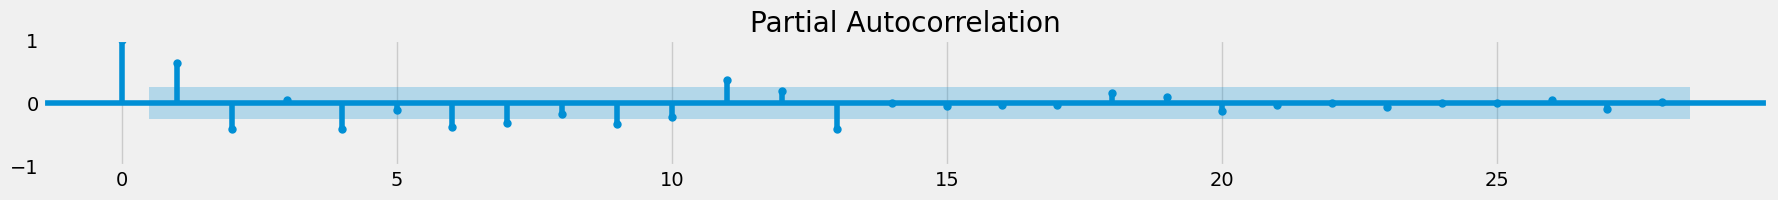

In [11]:
plt.subplot(413)
plot_pacf(decomposition.seasonal.dropna(), lags=28, ax=plt.gca())
plt.tight_layout()
plt.show()

In [12]:
log_transformed_data = np.log(correct_range)
log_transformed_data.head()

,listing_count
month_year,
2014-01-01,6.635947
2014-02-01,6.393591
2014-03-01,6.841615
2014-04-01,7.510431
2014-05-01,7.601402


In [29]:
log_transformed_data.isnull().sum()

listing_count    0
dtype: int64

In [13]:
log_transformed_data.columns

Index(['listing_count'], dtype='object')

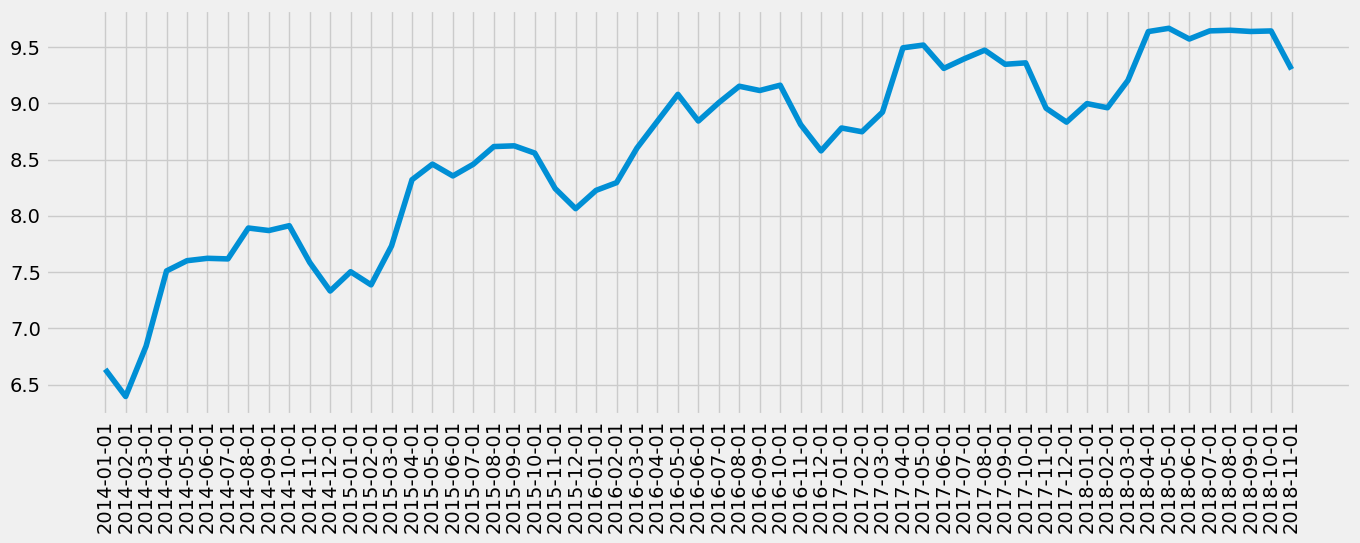

In [14]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(log_transformed_data)
plt.xticks(rotation=90)
plt.savefig('log_tranform_data', bbox_inches='tight', dpi=100)
plt.show()

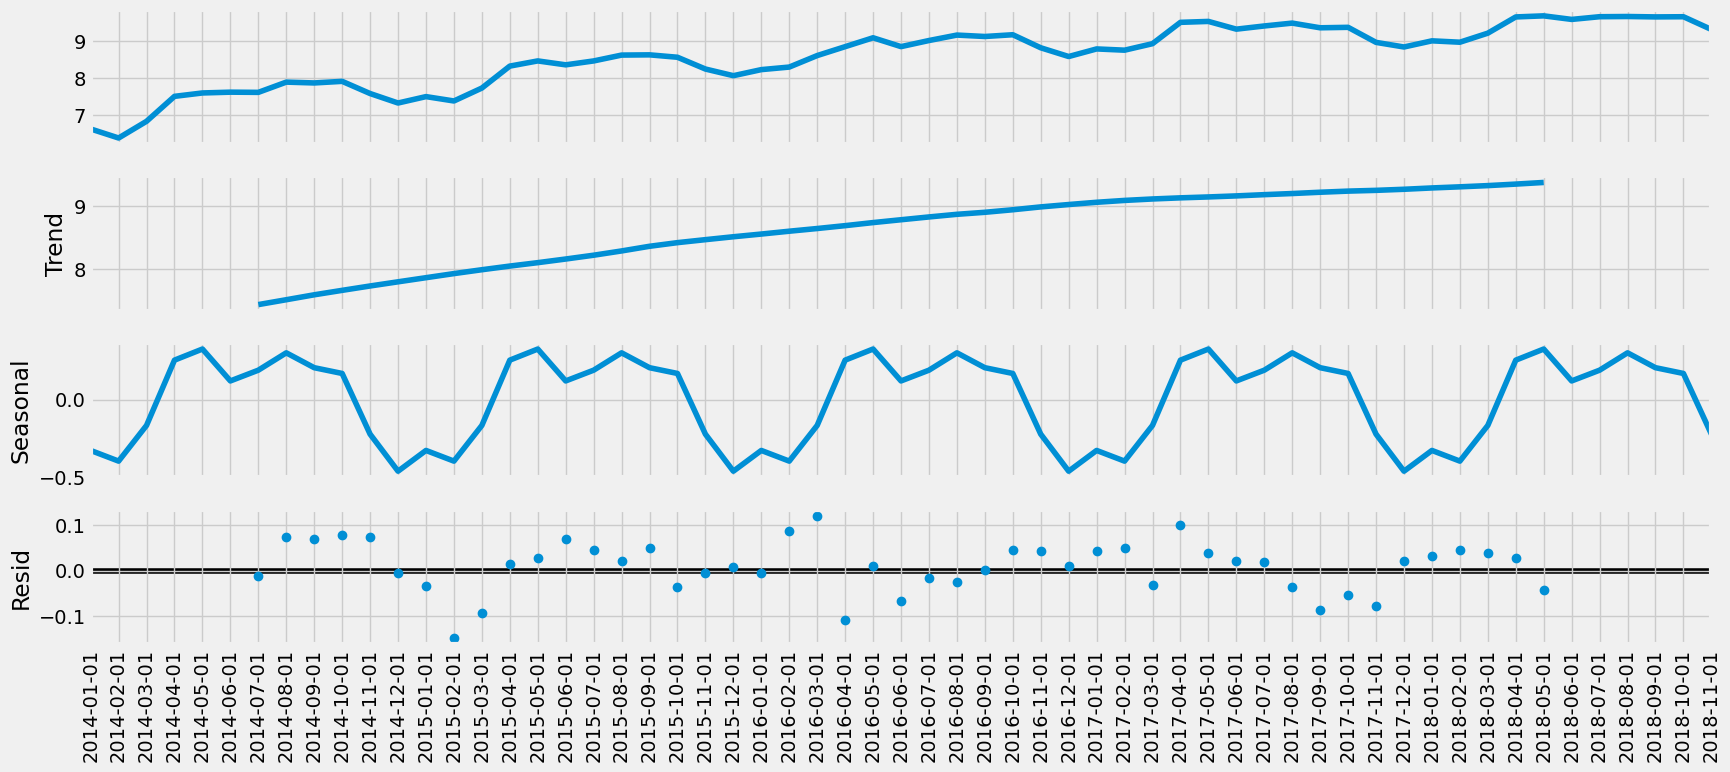

In [15]:
decomposition2 = sm.tsa.seasonal_decompose(log_transformed_data, model='additive', period=12)
decomposition2.plot()
plt.xticks(rotation=90)
plt.savefig('decomposition2_charts', bbox_inches='tight', dpi=100)
plt.show()

In [16]:
dickey_fuller(log_transformed_data)

Dickey-Fuller Stationarity test:
Test Statistic                -8.241073e+00
p-value                        5.715171e-13
Number of Lags Used            1.100000e+01
Number of Observations Used    4.700000e+01
Critical Value (1%)           -3.577848e+00
Critical Value (5%)           -2.925338e+00
Critical Value (10%)          -2.600774e+00
dtype: float64


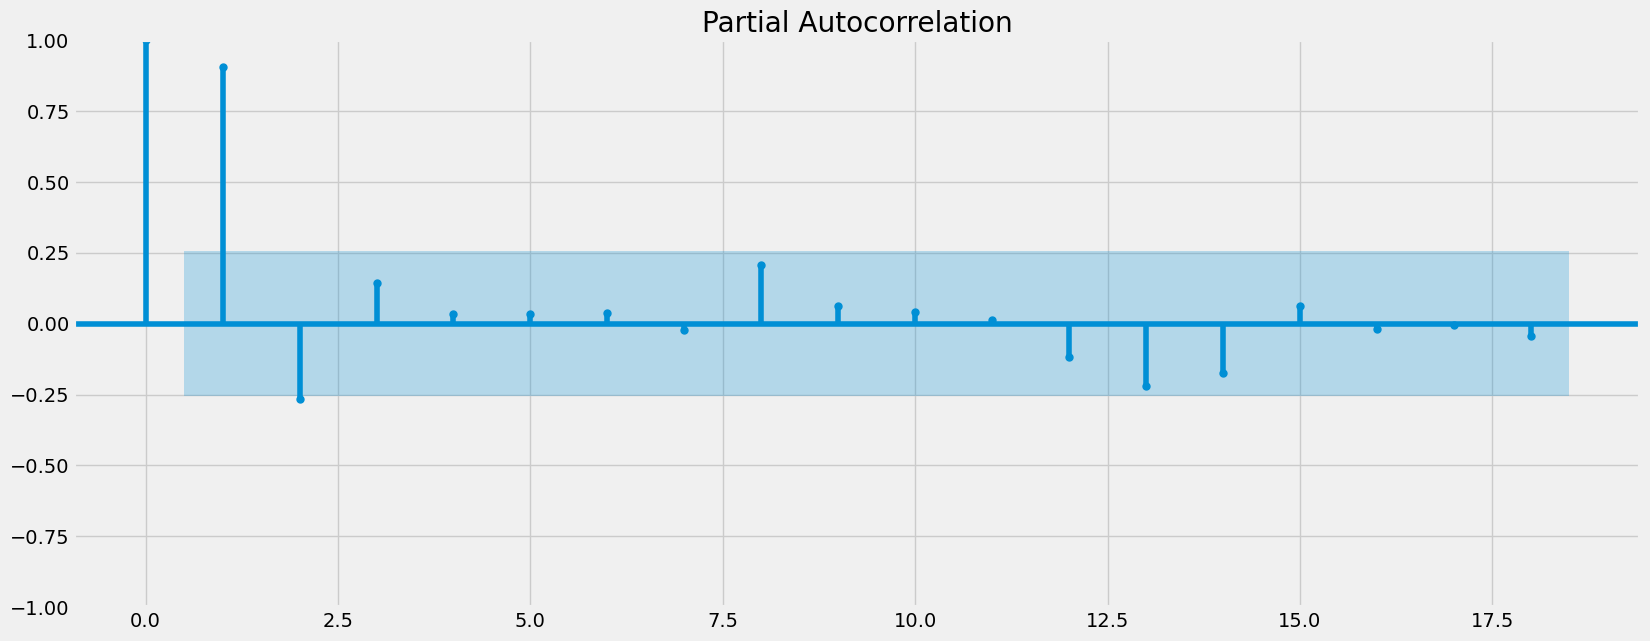

<Figure size 4500x4500 with 0 Axes>

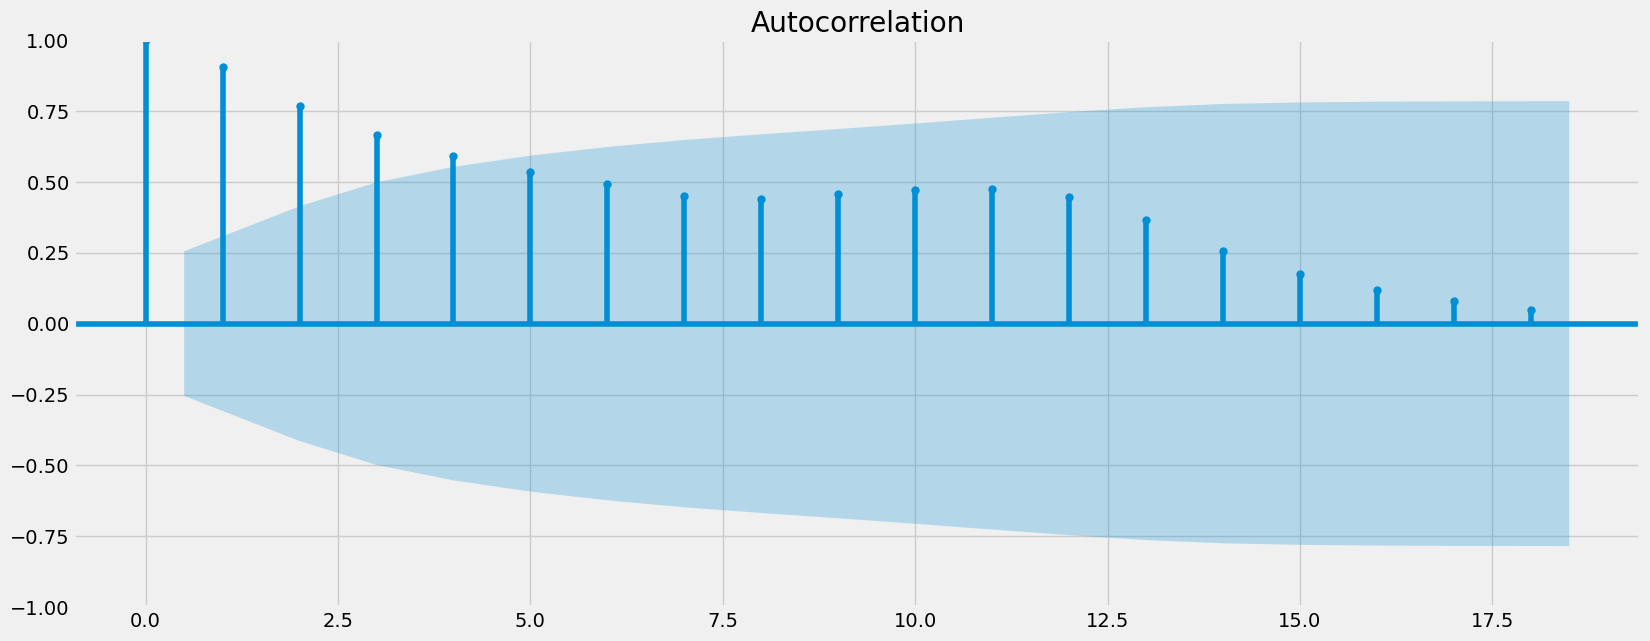

<Figure size 1500x500 with 0 Axes>

In [58]:
# Identifying seasonal parameters

plot_pacf(log_transformed_data)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

plot_acf(log_transformed_data)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

In [62]:
train = log_transformed_data['listing_count'][:45]
test = log_transformed_data['listing_count'][46:]
test.shape

(13,)

C:\Users\mojos\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mojos\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                       listing_count   No. Observations:                   45
Model:             SARIMAX(1, 1, 4)x(1, 0, [], 12)   Log Likelihood                  23.931
Date:                             Tue, 30 Apr 2024   AIC                            -33.863
Time:                                     21:22:34   BIC                            -21.373
Sample:                                 01-01-2014   HQIC                           -29.231
                                      - 09-01-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2515      0.748     -0.336      0.737      -1.718       1.215
ma.L1         -0.0396      

C:\Users\mojos\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\mojos\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


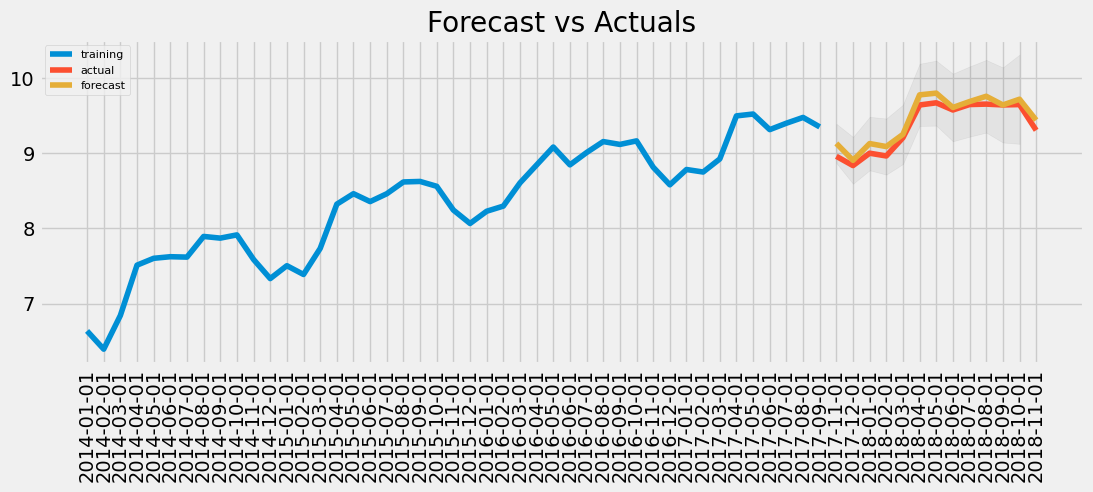

In [65]:
from statsmodels.tsa.api import ARIMA # Import the model you need

model = sm.tsa.statespace.SARIMAX(train, order=(1, 1, 4), seasonal_order=(1, 0, 0, 12))
fitted = model.fit()  
print(fitted.summary()) # Check model summary

forecast_values = fitted.forecast(14, alpha=0.05)
fc = forecast_values # Forecasted values
fc_series = pd.Series(fc, index=test.index) # This creates the forecasted curve
fc_dataframe = pd.DataFrame(fc, index=test.index)

forecast_object = fitted.get_forecast(steps=13, alpha=0.05)
conf_int = forecast_object.conf_int()

#Create pandas series for lower and upper bounds of the confidence interval
lower_series = pd.Series(conf_int.iloc[:, 0], index=test.index)
upper_series = pd.Series(conf_int.iloc[:, 1], index=test.index) # The above code uses
#iloc to access the columns of the conf_int DataFrame correctly, ensuring that the lower_series and upper_series are created with the appropriate data.#Plot the forecast and confidence interval

plt.figure(figsize=(12, 4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(test.index, lower_series, upper_series, color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(rotation=90)
plt.show()

### Visually, the forecasting line follows the actual plot with a high degree of accuracy. Statistically speaking, they may not pass the p-value score by being lower than the critical values, but given the subject matter, this isn't the end of the world. 

### Instead of using crit value results to prove model reliability I'll be exporting the forecasting and actual values to excel to quickly calculate the range of error.

In [66]:
fc_dataframe.head()

,predicted_mean
month_year,
2017-11-01,9.128827
2017-12-01,8.903468
2018-01-01,9.126842
2018-02-01,9.087016
2018-03-01,9.249208


In [67]:
actuals_vs_forecast = pd.concat([test, fc_dataframe], axis=1)
actuals_vs_forecast = actuals_vs_forecast.rename(columns={'listing_count': 'actuals','predicted_mean': 'forecast'})
actuals_vs_forecast

,actuals,forecast
month_year,,
2017-11-01,8.957639,9.128827
2017-12-01,8.834046,8.903468
2018-01-01,8.998755,9.126842
2018-02-01,8.962007,9.087016
2018-03-01,9.204825,9.249208
2018-04-01,9.639652,9.774361
2018-05-01,9.668651,9.797170
2018-06-01,9.573315,9.606588
2018-07-01,9.645688,9.685045


In [68]:
actuals_vs_forecast['difference'] = actuals_vs_forecast['actuals'] - actuals_vs_forecast['forecast']

In [70]:
actuals_vs_forecast

,actuals,forecast,difference
month_year,,,
2017-11-01,8.957639,9.128827,-0.171188
2017-12-01,8.834046,8.903468,-0.069422
2018-01-01,8.998755,9.126842,-0.128088
2018-02-01,8.962007,9.087016,-0.125008
2018-03-01,9.204825,9.249208,-0.044383
2018-04-01,9.639652,9.774361,-0.134709
2018-05-01,9.668651,9.797170,-0.128519
2018-06-01,9.573315,9.606588,-0.033273
2018-07-01,9.645688,9.685045,-0.039357


In [71]:
actuals_vs_forecast.to_clipboard()

#### Values were exported and reviewed in Excel to calculate the error range of the forecasted values. The forecast generated predictions that were on average 10% higher than the actuals (error range being between 4% and 13% over). 

#### Given that these figures are only meant to be estimations of where the channel could grow too within the upcoming period(s)I think an estimated 10% margin of error isn't too outlandish. If we were dealing with my concrete data, then perhaps we'd aim for stronger, more significant results.